<a href="https://colab.research.google.com/github/merrymasti015/CAP2022GRP09/blob/main/PCAMZC321_Group09_FireEventDetection_InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing packages 

In [1]:
import os                                     # operating system 
import numpy as np                            # linear algebra 
from PIL import Image                         # Python image library 
import matplotlib.pyplot as plt               # making plots
%matplotlib inline 
from IPython.display import display           # displaying ?

import warnings                               # ignoring unnecessary python warnings 
warnings.filterwarnings('ignore')

#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow import keras as keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2             # pretrained CNN                        
from keras.callbacks import ModelCheckpoint                  # furter train the saved model 
from keras import models, layers, optimizers                 # building DNN is keras 
from tensorflow.keras.models import load_model               # load saved model 
from keras.preprocessing.image import ImageDataGenerator     # preparing image data for training 

from keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

ModelSaveFolder = "/content/gdrive/MyDrive/Fire_ImageDataSet/ModelSave"


Drive = "/content/gdrive/MyDrive/"
## Define root folder
RootFolder = Drive+"Fire_ImageDataSet/OutputFiles"

### Where to save models

ModelSaveFolder = Drive+"Fire_ImageDataSet/ModelSave"

print(ModelSaveFolder)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Fire_ImageDataSet/ModelSave


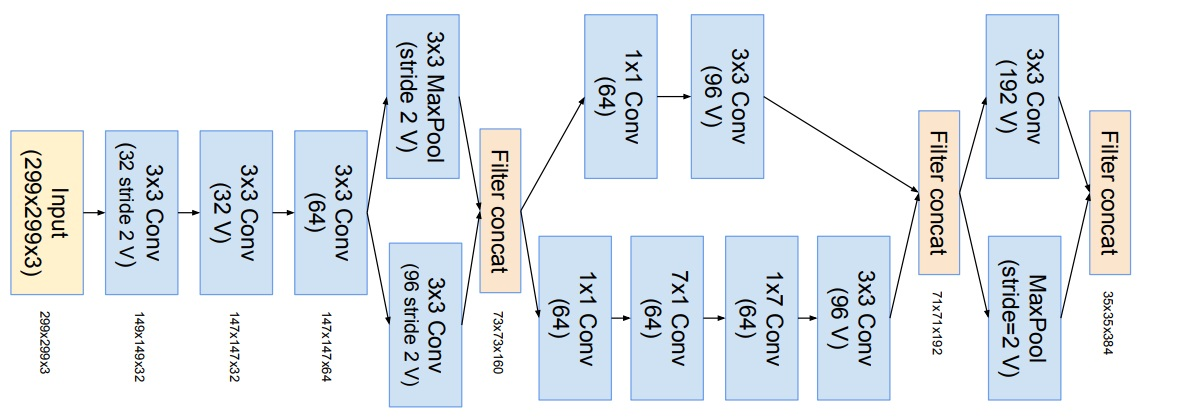

In [3]:
from IPython import display
display.Image(Drive+"inception_resnet_v2.jpg")

#### Setting up model 

We set the model with InceptionResNetV2 base and custom top. 

- Loss: Since this is classification problem and there are two classes, we use the binary cross-entropy as the loss function. 

- Optimizer: We use RMSprop optimizer with customized learning rate. 

- Metrics: In addition to the loss we want to observe the accuracy. We optimize our model based on this metric.

## A typical transfer learning workflow can be implemented in Keras:

Instantiate a base model and load pre-trained weights into it.
Freeze all layers in the base model by setting trainable = False.
Create a new model on top of the output of one (or several) layers from the base model.
Train your new model on your new dataset.

In [4]:
conv_base = InceptionResNetV2(weights='imagenet', # Load weights pre-trained on ImageNet.
                 include_top=False,               # Do not include the ImageNet classifier at the top.
                 input_shape=(150, 150, 3))




#conv_base = (weights='imagenet',                  # Load weights pre-trained on ImageNet.
#                include_top=False,               # Do not include the ImageNet classifier at the top.
#                input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


219070464/219055592 [==============================] - 2s 0us/step


Here is the summary of the model. 

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 13824)             0         
                                                                 
 dense (Dense)               (None, 256)               3539200   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


Before we can compile and train our model, we need to “freeze” our conv_base to prevent base layer weights from getting updated during training. This is a critical step; If we don’t do this then it will effectively destroy the previously learnt representations and would defeat the purpose of using a pre-trained model base.

We can “freeze” the convo_base” layer by setting its trainable attribute to “False,” as shown below. But first, let’s verify the number of trainable attributes before setting the flag:

In [6]:
print('Trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))


Trainable weights before freezing the conv base: 492


In [7]:
conv_base.trainable = False # freeze the base model.

In [8]:
print('Trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

Trainable weights after freezing the conv base: 4


In [9]:
base_dir = '/content/gdrive/MyDrive/Fire_ImageDataSet/OutputFiles/BaseDataSet'

train_dir = os.path.join(base_dir, 'Train')
train_dir_fire = os.path.join(train_dir, 'Fire')
train_dir_nofire = os.path.join(train_dir, 'Neutral')

test_dir = os.path.join(base_dir, 'Test')
test_dir_fire = os.path.join(test_dir, 'Fire')
test_dir_nofire = os.path.join(test_dir, 'Neutral')

# Preparing the data 

#### Calling test and train image directories 

These directories were prepared in the other notebook. 

In [10]:
train_dir_nofire

'/content/gdrive/MyDrive/Fire_ImageDataSet/OutputFiles/BaseDataSet/Train/Neutral'

In [11]:
list = os.listdir(train_dir_fire) # dir directory path
number_files = len(list)
print(number_files)

875


In [12]:
list = os.listdir(train_dir_nofire) # dir directory path
number_files = len(list)
print(number_files)

900


In [13]:
list = os.listdir(test_dir_fire) # dir directory path
number_files = len(list)
print(number_files)

97


In [14]:
list = os.listdir(test_dir_nofire) # dir directory path
number_files = len(list)
print(number_files)

90


In [15]:
#from keras.preprocessing.image import ImageDataGenerator
'''
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
'''
train_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



Found 1775 images belonging to 2 classes.
Found 187 images belonging to 2 classes.


In [16]:
train_generator.samples 

1775

In [17]:
test_generator.samples 

187

In [18]:
import tensorflow as tf
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


# Training the model 

We pass the training data from the train_generator. We train for 30 epochs. We pass the validation data from the validation_generator.  We get validation accuracy above to 90% from this. 

In [19]:
history = model.fit(train_generator, epochs=25, 
                    validation_data=test_generator)

Epoch 1/25
89/89 [==============================] - 397s 4s/step - loss: 0.2763 - acc: 0.8901 - val_loss: 0.1831 - val_acc: 0.9305
Epoch 2/25
89/89 [==============================] - 16s 185ms/step - loss: 0.1551 - acc: 0.9397 - val_loss: 0.1485 - val_acc: 0.9626
Epoch 3/25
89/89 [==============================] - 16s 182ms/step - loss: 0.1283 - acc: 0.9504 - val_loss: 0.1481 - val_acc: 0.9626
Epoch 4/25
89/89 [==============================] - 16s 183ms/step - loss: 0.0983 - acc: 0.9623 - val_loss: 0.1441 - val_acc: 0.9572
Epoch 5/25
89/89 [==============================] - 16s 179ms/step - loss: 0.0981 - acc: 0.9606 - val_loss: 0.2140 - val_acc: 0.9465
Epoch 6/25
89/89 [==============================] - 16s 185ms/step - loss: 0.1145 - acc: 0.9611 - val_loss: 0.1278 - val_acc: 0.9679
Epoch 7/25
89/89 [==============================] - 16s 183ms/step - loss: 0.0895 - acc: 0.9685 - val_loss: 0.1483 - val_acc: 0.9679
Epoch 8/25
89/89 [==============================] - 16s 182ms/step - lo

### Overall 95% accuracy 

Saving the model for the future use. 

In [20]:
# Saving Model
model_name = 'InceptionResNetV2_suns.h5'
#model_name = 'InceptionResNetV2.h5'
model.save(ModelSaveFolder+'/'+model_name)

In [21]:
from tensorflow import keras

model = keras.models.load_model(ModelSaveFolder+'/'+model_name)

#### Visualization of the learning 

Training gives four sets of values in each eopch

- Training accuracy 
- Validation accuracy 
- Training loss 
- Validation loss 

In [22]:
# Dictionary to extract the numbers 
hist_dict = history.history

# Training and validation accuracy 
training_acc = hist_dict['acc']
validation_acc = hist_dict['val_acc']

# Training and validation loss 
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs 
epoches = range(1, 1 + len(training_acc))

#### Function to make plot 

In [23]:
def plot_func(entity):
    
    '''
    This function produces plot to compare the performance 
    between train set and validation set. 
    entity can be loss of accuracy. 
    '''
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()

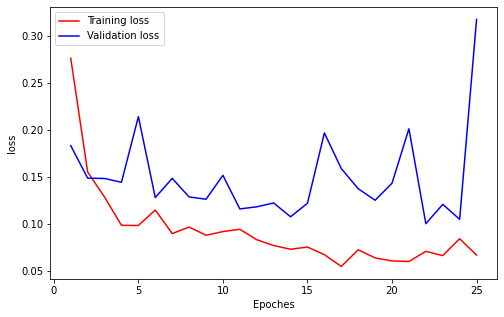

In [24]:
plot_func('loss')

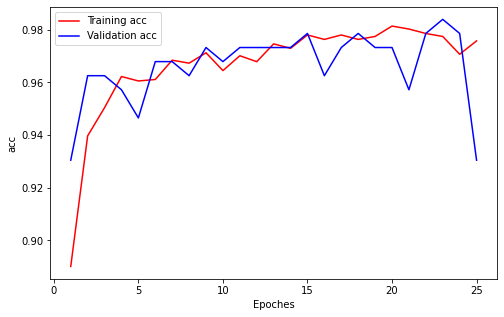

In [25]:
plot_func('acc')

#### Getting the labels and predictions 

In [26]:
len(test_generator)

#test_generator

10

In [27]:
# taking first batch from the generator 
img, label = test_generator[5] 
print(label)
print(img)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1.]
[[[[0.6666667  0.54509807 0.53333336]
   [0.43137258 0.30980393 0.29803923]
   [0.41176474 0.2784314  0.27450982]
   ...
   [0.41176474 0.28235295 0.3254902 ]
   [0.40784317 0.2784314  0.32156864]
   [0.5647059  0.46274513 0.49803925]]

  [[0.427451   0.30588236 0.29411766]
   [0.19215688 0.07058824 0.05882353]
   [0.1764706  0.04313726 0.03921569]
   ...
   [0.13725491 0.00784314 0.0509804 ]
   [0.13333334 0.00392157 0.04705883]
   [0.41176474 0.30980393 0.34509805]]

  [[0.47058827 0.34901962 0.3372549 ]
   [0.2392157  0.11764707 0.10588236]
   [0.21960786 0.08627451 0.08235294]
   ...
   [0.21960786 0.07843138 0.1254902 ]
   [0.21176472 0.07058824 0.11764707]
   [0.427451   0.3254902  0.36078432]]

  ...

  [[0.8470589  0.7254902  0.7843138 ]
   [0.7686275  0.64705884 0.7058824 ]
   [0.7686275  0.6431373  0.7019608 ]
   ...
   [0.9294118  0.7686275  0.7843138 ]
   [0.854902   0.7686275  0.7803922 ]
   [1.         0.988235

In [28]:
# taking first batch from the generator 
img, label = test_generator[0] 

# Predicting the images from the first batch 
pred = np.round(model.predict(img)).flatten()

In [29]:
len(img)

20

In [30]:
pred

array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0.], dtype=float32)

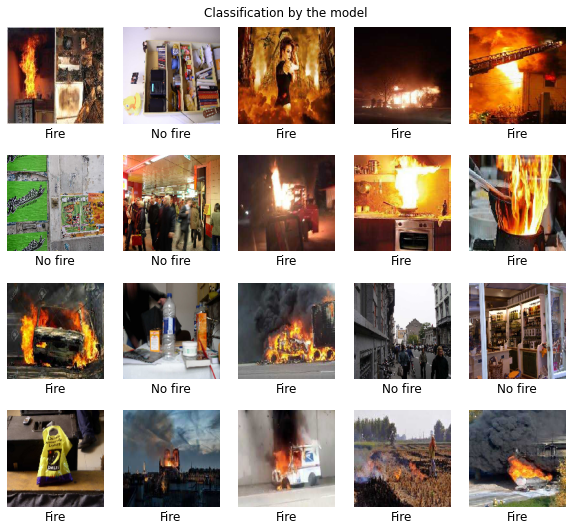

In [31]:
# Numeric to semantic labels 
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots 
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(4, 5, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)

#### Extracting misclassified images

In [32]:
print(range(len(test_generator)))

range(0, 10)


In [33]:
# Lists for missed fire images and missed non-fire images
msd_fire = []
msd_nofire = []

def compareList(stringList,paramValue):
    return [i==j for i, j in zip(stringList, paramValue)]

# Iterating through all the batches 
#for j in range(31):
for j in range(len(test_generator)):
    print(j)
    img, label = test_generator[j] 
    pred = np.round(model.predict(img)).flatten()
    bool_list = compareList(label,pred)

    # bool_list is False when there is misclassification 
    for i, e in enumerate(bool_list):
        if e == False:
            
            # separating labels (fire and non-fire)
            if label[i] == 0:
                msd_fire.append(img[i])
            else:
                msd_nofire.append(img[i])

0
1
2
3
4
5
6
7
8
9


#### Confusion matrix

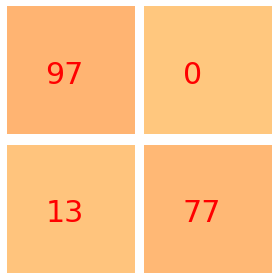

In [34]:
import pandas as pd
# total number of sample in test set in each class 
#n_class = 195

# number of misclassified fire and non-fire images 
#nm_fire, nm_nofire = len(msd_fire), len(msd_nofire)

# total number of sample in test set in each class 
n_classFire    = 97
n_classNeutral = 90

# number of misclassified fire and non-fire images 
nm_fire, nm_nofire = len(msd_fire), len(msd_nofire)

# confusion matrix (flattened)
conf_mat = [n_classFire-nm_fire, nm_fire, nm_nofire, n_classNeutral-nm_nofire]

# confusion matrix (flattened)
#conf_mat = [n_class-nm_fire, nm_fire, nm_nofire, n_class-nm_nofire]

tp = n_classFire-nm_fire
fn = nm_fire
fp = nm_nofire
tn = n_classNeutral-nm_nofire
precision_fire=tp/(tp+fp)                                                              # Precision = TruePositives / (TruePositives + FalsePositives)
recall_fire= tp/(tp+fn)                                                                # Recall = TruePositives / (TruePositives + FalseNegatives)
f1_fire= 2*precision_fire*recall_fire/(precision_fire*recall_fire)                     # (2 * Precision * Recall) / (Precision + Recall)
precision_Neutral=tn/(tn+fn)                                                           # Precision = TruePositives / (TruePositives + FalsePositives)
recall_Neutral= tn/(tn+fp)                                                             # Recall = TruePositives / (TruePositives + FalseNegatives)
f1_Neutral= 2*precision_Neutral*recall_Neutral/(precision_Neutral*recall_Neutral)      # (2 * Precision * Recall) / (Precision + Recall)
eval_data_for_all_models = pd.DataFrame()
model_name = 'InceptionResNetV2_suns'
eval_data_for_all_models=pd.DataFrame()
eval_data_for_all_models['model_name'] = [model_name]
eval_data_for_all_models['precision_fire'] = [precision_fire]
eval_data_for_all_models['recall_fire'] = [recall_fire]
eval_data_for_all_models['f1_fire'] = [f1_fire]
eval_data_for_all_models['precision_Neutral'] = [precision_Neutral]
eval_data_for_all_models['recall_Neutral'] = [recall_Neutral]
eval_data_for_all_models['f1_Neutral'] = [f1_Neutral]

#Model_acc,roc_auc=plot_roc_curve(model,test_set[0] ,pred)
#eval_data_for_all_models['model_accuracy'] = [Model_acc]
#eval_data_for_all_models['ROC_AUC'] = [roc_auc]

eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval_inception_resnet_v2.csv',header=True, index=False)

# visualization of confusion matrix 
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='copper_r')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter 
fig.tight_layout()
fig.show()

#### Showing mis-classified fire images 

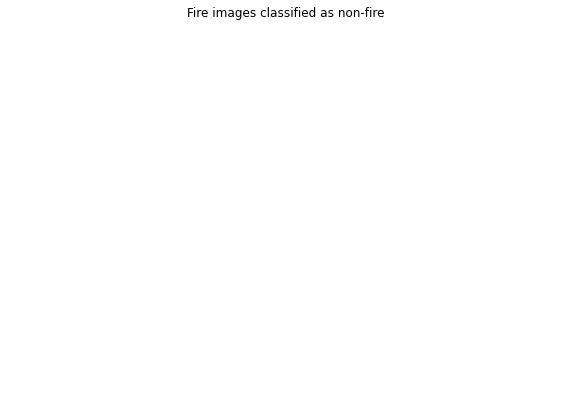

In [43]:
fig = plt.figure(figsize=(10, 7))
plt.title('Fire images classified as non-fire')
plt.axis('off')
for i, img_i in enumerate(msd_fire):        
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

Some of the misclassified figure have fire but that is too small. So even human observer is easy to confuse with them. Though some of the big explicit fire images are misclassified too. May be that is painting of fire but not the picture. Misclassified fire images are mostly bonfire, stove fire, fire tourch, kitchen fire etc. This is not big surprise because there were not enough fire sample in training set in that categories.  

#### Showing mis-classified non-fire images. 

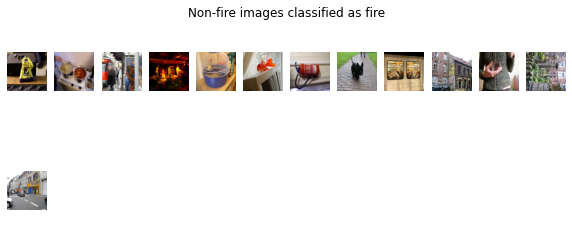

In [45]:
fig = plt.figure(figsize=(10, 4))
plt.title('Non-fire images classified as fire')
plt.axis('off')
for i, img_i in enumerate(msd_nofire):        
    ax = fig.add_subplot(2, 12, i+1)
    ax.imshow(img_i)
    ax.axis('off')

## Apply On Unlabeled images 

## Upto this - 23-03-22

In [46]:
import matplotlib.image as mpimg  # To view  image 
from pathlib import Path

In [47]:
from tensorflow import keras
model_name = 'InceptionResNetV2_suns.h5'
InceptionResNetV2 = model

In [51]:
imageFolder = Drive+"/Fire_ImageDataSet/ApplySet"
imageFolder

'/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet'

In [52]:
def image_collage(path, n_rows, n_cols, title ,pred , pred_results,ModelName):
    
    '''This function selects the first few images from given 
    path and presents in the collage form. 
    path is the directory from which images are taken. 
    n_rows and n_cols are rows and column of the collage. 
    title is the title of the collage.
    imageType - to indicate colur(C) or grey (G)'''
    
    # Initiating the plot 
    fig = plt.figure()
    plt.title(title)
    
    # Turns off axis from the collage (total plot)
    plt.axis('Off')
    
    # List of all images in the path
    img_list = os.listdir(path)
    # Numeric to semantic labels 
    label_dict = {0: 'fire', 1: 'No Fire'}
    img_num = 1
    i=0
    for img in img_list:
        
        # directroies of the choosen images 
        img_path = os.path.join(path, img)
        print(img_path)
        # showing the color images 
        #img_read = mpimg.imread(img_path)
        img_read = mpimg.imread(img_path)
        

       # collage is formed from subplot
        ax = fig.add_subplot(n_rows, n_cols, img_num)
        img_num += 1
        temp = Path(img_path).stem # Find file name without extension
        if pred_results == 'Y':   ### for printing prediction output
            if ModelName == 'CNN_SVM' or ModelName == 'InceptionResNetV2':
                cnnPred           = pred[0][i]
                class_prediction  = label_dict[cnnPred]
            else:
                class_prediction  = label_dict[pred[0]]
            
            temp = temp+"(" + class_prediction + ')'
            i=i+1
                                                                         
        #plt.title(temp)
        # displaying image in subplot 
        ax.imshow(img_read)
        ax.text(5, 5, temp, bbox=dict(facecolor='white', alpha=0.8))
        
        # turns off the axis from individual image in the collage
        ax.axis('Off')

/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet/fire1.jpg
/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet/fire2.jpg
/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet/neutral1.jpg
/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet/neutral2.jpg


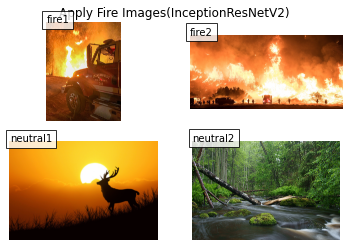

In [54]:
pred_results = 'N'
ModelName = 'InceptionResNetV2'
Title = 'Apply Fire Images'+'('+ ModelName +')'
pred = 0
image_collage(imageFolder,2,2,Title , pred, pred_results,ModelName )

In [55]:
from keras.preprocessing import image

In [56]:
###  predict_on_Apply_Image
def  predict_on_Apply_Image(path , model):
    

     prediction_images = []
     base_images = []
     # Numeric to semantic labels 
     #label_dict = {0: 'fire', 1: 'No Fire'}
     i = 0
     
     # List of all images in the path
     img_list = os.listdir(path)

     for Imagefile in img_list:
            # directroies of the choosen images 
            img_path = os.path.join(path, Imagefile)
            
            img = image.load_img(img_path, target_size=(150, 150, 3))
            base_images.append(img_path)
            #base_images.append(img)
            img = image.img_to_array(img)
            # normalizing the pixel value
            img = img/255
            # appending the image to the image list
            prediction_images.append(img)
            #print("Prediction:" , prediction_images)
     
     # converting the list to numpy array
     prediction_images = np.array(prediction_images)
     #print(prediction_images.shape)
     # predicting class for each array
     #pred = np.round(model.predict(prediction_images)).flatten()
     #pred = model.predict_classes(prediction_images)
     predict_x=model.predict(prediction_images)
     pred = np.argmax(predict_x,axis=-1)     
     print(pred)
     return pred

In [57]:

prediction = predict_on_Apply_Image(imageFolder,model)

[0 0 0 0]


In [58]:
prediction= prediction.T

/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet/fire1.jpg
/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet/fire2.jpg
/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet/neutral1.jpg
/content/gdrive/MyDrive//Fire_ImageDataSet/ApplySet/neutral2.jpg


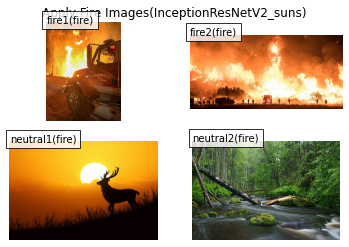

In [59]:
pred_results = 'Y'
ModelName = 'InceptionResNetV2_suns'
Title = 'Apply Fire Images'+'('+ ModelName +')'
pred = 0
image_collage(imageFolder,2,2,Title , prediction, pred_results,ModelName )

##  E N D 